In [10]:
import findspark
from pyspark.sql import SparkSession
from functions.required_functions import readFile, normalize, transform, get_block_data, train, accuracy, cost, predict_proba
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
GRADIENT_ITERATIONS = 10

# Experiment #1 Hyperparameter exploration: learning rate and regularization

In [17]:
spark = SparkSession.builder.master("local[*]").appName('Exercise_1').getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/22 11:30:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/22 11:30:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Ajustando el Learning rate

In [29]:
# Create a new train function that returns histyry of cost and accuracy for each iteration

from pyspark import RDD

def train_trace(rdd_xy: RDD, iterations: int, learning_rate: float, lambda_reg: float) -> dict:
    k = len(rdd_xy.first()[0])
    m = rdd_xy.count()
    w = np.random.rand(k)
    b = 0
    return_dict = {"cost": [], "accuracy": [], "w": [], "b": []}
    for it in range(iterations):
        # Gradients
        dw = (
            rdd_xy.map(lambda x: (predict_proba(w, b, x[0]) - x[1]) * np.array(x[0]))
            .reduce(lambda x, y: x + y) / m
        )
        db = (
            rdd_xy.map(lambda x: predict_proba(w, b, x[0]) - x[1])
            .reduce(lambda x, y: x + y) / m
        )

        # Regularization
        dw += lambda_reg / k * w

        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db
        return_dict["cost"].append(cost(w, b, rdd_xy, lambda_reg, k, m))
        return_dict["accuracy"].append(accuracy(w, b, rdd_xy))


    return_dict["w"] = w
    return_dict["b"] = b
    return return_dict

In [42]:
path = "/opt/local/botnet_tot_syn_l.csv"  # botnet_tot_syn_l.csv // botnet_reduced_10k_l.csv
nIter = 10
learning_rates = [0.01, 0.1, 0.3,  0.5, 0.8 , 1.0, 1.3, 1.5, 2.0, 3.0, 5.0]
lambda_reg = 0


# Read data
data = readFile(path,sc).cache()
print(f"Total samples: {data.count()}")

# Standardize
data = normalize(data)
print("Data normalized.")

sums, n = data.map(lambda x: (x[0], 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
medias = sums / n
desvs = (data.map(lambda x: (x[0]-medias)**2).reduce(lambda x, y: x + y) / (n-1))**0.5

all_results = []
for i in range(len(learning_rates)):
    print(f"Experiment {i+1} Training with learning rate: {learning_rates[i]}")
    lr = learning_rates[i]
    results = train_trace(data, nIter, lr, lambda_reg)
    all_results.append(results)

Total samples: 1000000


Data normalized.


26/02/22 12:07:55 WARN BlockManager: Task 3244 already completed, not releasing lock for rdd_1659_0


Experiment 1 Training with learning rate: 0.01


26/02/22 12:09:38 WARN BlockManager: Task 3614 already completed, not releasing lock for rdd_1659_0


Experiment 2 Training with learning rate: 0.1


Experiment 3 Training with learning rate: 0.3


26/02/22 12:11:33 WARN BlockManager: Task 3984 already completed, not releasing lock for rdd_1659_0


Experiment 4 Training with learning rate: 0.5


26/02/22 12:13:18 WARN BlockManager: Task 4354 already completed, not releasing lock for rdd_1659_0
26/02/22 12:15:20 WARN BlockManager: Task 4724 already completed, not releasing lock for rdd_1659_0


Experiment 5 Training with learning rate: 0.8


26/02/22 12:17:07 WARN BlockManager: Task 5094 already completed, not releasing lock for rdd_1659_0


Experiment 6 Training with learning rate: 1.0


26/02/22 12:19:12 WARN BlockManager: Task 5464 already completed, not releasing lock for rdd_1659_0


Experiment 7 Training with learning rate: 1.3


Experiment 8 Training with learning rate: 1.5


26/02/22 12:21:14 WARN BlockManager: Task 5834 already completed, not releasing lock for rdd_1659_0
26/02/22 12:23:07 WARN BlockManager: Task 6204 already completed, not releasing lock for rdd_1659_0


Experiment 9 Training with learning rate: 2.0


26/02/22 12:25:05 WARN BlockManager: Task 6574 already completed, not releasing lock for rdd_1659_0


Experiment 10 Training with learning rate: 3.0


Experiment 11 Training with learning rate: 5.0


26/02/22 12:27:24 WARN BlockManager: Task 6944 already completed, not releasing lock for rdd_1659_0


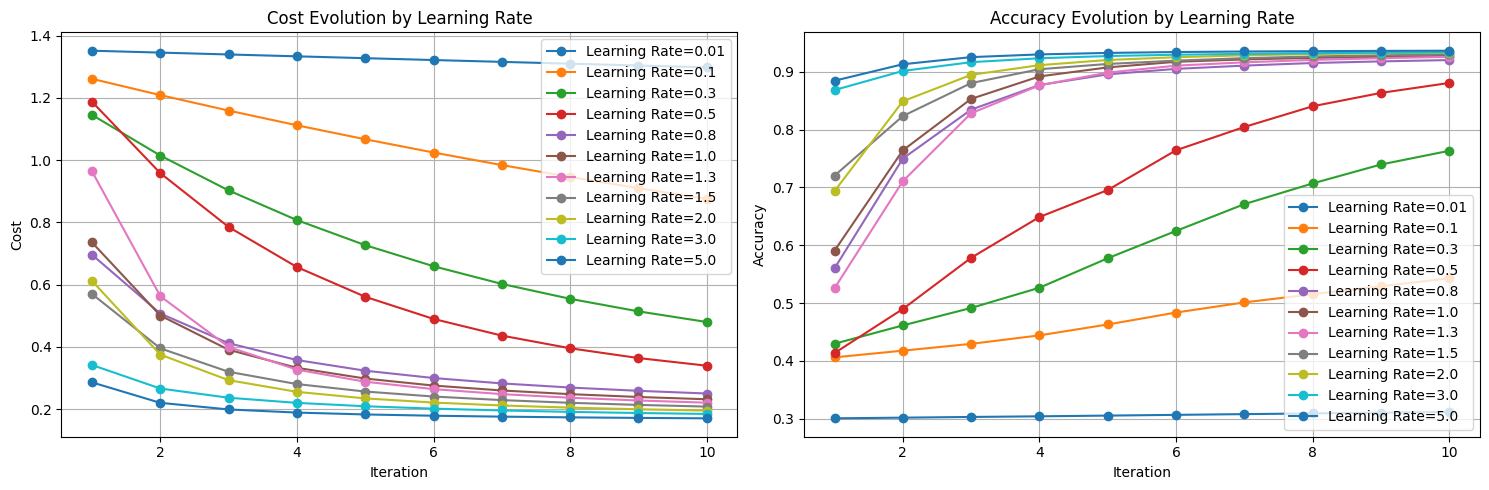

In [ ]:

def plot_results(all_results, variables, var_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot cost evolution for each variable value
    for i, var in enumerate(variables):
        ax1.plot(range(1, nIter + 1), all_results[i]['cost'], marker='o', label=f'{var_name}={var}')

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost')
    ax1.set_title(f'Cost Evolution by {var_name}')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy evolution for each variable value
    for i, var in enumerate(variables):
        ax2.plot(range(1, nIter + 1), all_results[i]['accuracy'], marker='o', label=f'{var_name}={var}')

    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'Accuracy Evolution by {var_name}')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_results(all_results, learning_rates, "Learning Rate")

### Conclusionnes Learning rate

Learning rates altos nos hacen converger más rápido, pero pueden causar oscilaciones y divergencia. Learning rates bajos convergen de manera más estable pero pueden tardar mucho tiempo en alcanzar una buena solución. Es importante encontrar un balance adecuado para cada problema específico.

## Ajustando al regularizacion

In [39]:
path = "/opt/local/botnet_reduced_10k_l.csv"  # botnet_tot_syn_l.csv // botnet_reduced_10k_l.csv
nIter = 10
learning_rate = 1.5
lambda_reg = [0, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9]


# Read data
data = readFile(path,sc).cache()
print(f"Total samples: {data.count()}")

# Standardize
data = normalize(data)
print("Data normalized.")

sums, n = data.map(lambda x: (x[0], 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
medias = sums / n
desvs = (data.map(lambda x: (x[0]-medias)**2).reduce(lambda x, y: x + y) / (n-1))**0.5

all_results = []
for i in range(len(lambda_reg)):
    print(f"Experiment {i+1} Training with lambda regularization: {lambda_reg[i]}")
    results = train_trace(data, nIter, learning_rate, lambda_reg[i])
    all_results.append(results)

Total samples: 10000
Data normalized.
Experiment 1 Training with lambda regularization: 0
Experiment 2 Training with lambda regularization: 0.01
Experiment 3 Training with lambda regularization: 0.1
Experiment 4 Training with lambda regularization: 0.3
Experiment 5 Training with lambda regularization: 0.5
Experiment 6 Training with lambda regularization: 0.7
Experiment 7 Training with lambda regularization: 0.9


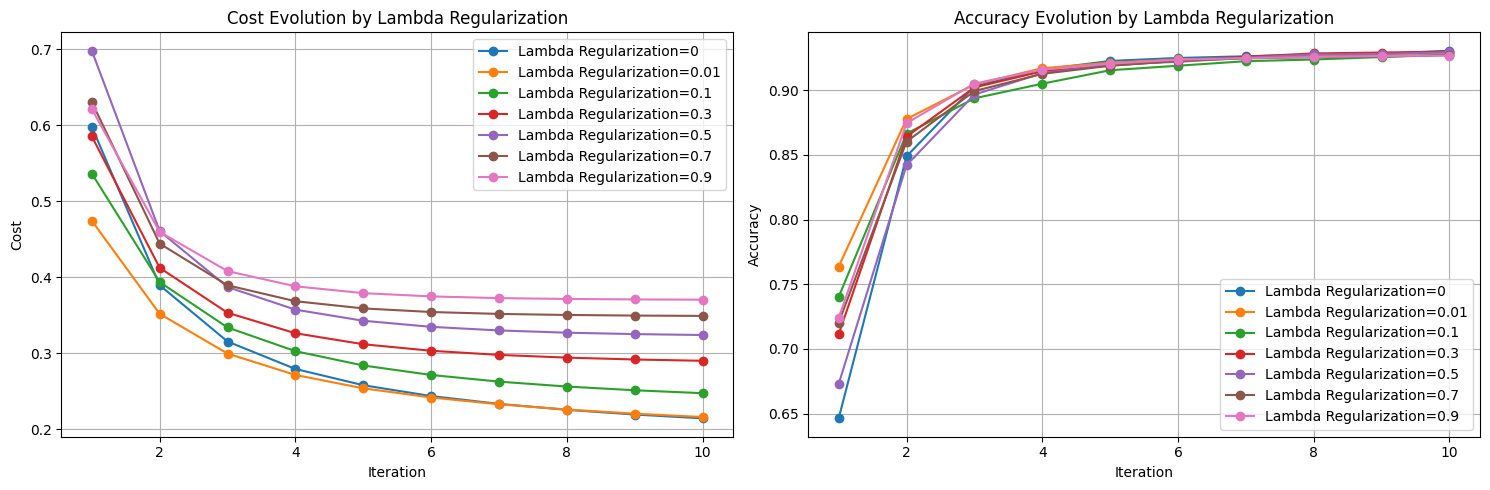

In [41]:
plot_results(all_results, lambda_reg, "Lambda Regularization")

### Conclusiones regularizacion

La regularización ayuda a prevenir el sobreajuste al penalizar los pesos grandes. Un lambda de regularización demasiado alto puede llevar a un modelo subajustado, mientras que un lambda demasiado bajo puede no ser suficiente para evitar el sobreajuste. En este caso vemos que para 0 es la mejor evoluvión de coste.

In [52]:
# Borramos el contexto de Spark
sc.stop()

# Experiment #2 Performance and speed-up analysis based on the number of workers and partitions 

In [3]:
LEARNING_RATE = 1.5
LAMBDA_REG = 0.0

In [4]:
num_cores = os.cpu_count()
num_cores

16

In [5]:
num_parts_workers = range(1, num_cores + 3)
print(f"Probaremos con el número de workers y particiones: {list(num_parts_workers)}")

Probaremos con el número de workers y particiones: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [6]:
import time

In [ ]:
filename = "/opt/local/botnet_tot_syn_l.csv"
results = []
for num_pw in num_parts_workers:
    dict_results = {"num_workers_partitions": num_pw}
    print(f"Experiment with {num_pw} partitions/workers")
    start_time = time.time()
    spark = SparkSession.builder.master(f"local[{num_pw}]").appName(f"Test-{num_pw}-workers").getOrCreate()
    sc = spark.sparkContext
    # Read data
    data = readFile(filename,sc)
    data = data.repartition(num_pw)
    print(f"Confirming number of partitions: {data.getNumPartitions()}")
    data = normalize(data)
    w_b = train(data, GRADIENT_ITERATIONS, LEARNING_RATE, LAMBDA_REG)
    end_time = time.time()
    dict_results["execution_time"] = end_time - start_time
    print(f"Execution time for {num_pw} workers/partitions: {dict_results['execution_time']} seconds")
    results.append(dict_results)
    spark.stop()

Experiment with 1 partitions/workers


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/22 13:17:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Confirming number of partitions: 1


Iteration 0/10, Cost: 0.6196, Accuracy: 0.6830


Iteration 1/10, Cost: 0.4105, Accuracy: 0.8219


Iteration 2/10, Cost: 0.3273, Accuracy: 0.8814


Iteration 3/10, Cost: 0.2857, Accuracy: 0.9030


Iteration 4/10, Cost: 0.2610, Accuracy: 0.9131


Iteration 5/10, Cost: 0.2447, Accuracy: 0.9189


Iteration 6/10, Cost: 0.2329, Accuracy: 0.9232


Iteration 7/10, Cost: 0.2241, Accuracy: 0.9255


Iteration 8/10, Cost: 0.2172, Accuracy: 0.9274


Iteration 9/10, Cost: 0.2115, Accuracy: 0.9287
Execution time for 1 workers/partitions: 308.16026401519775 seconds
Experiment with 2 partitions/workers
Confirming number of partitions: 2


Iteration 0/10, Cost: 0.6446, Accuracy: 0.6750


Iteration 1/10, Cost: 0.4195, Accuracy: 0.8413


Iteration 2/10, Cost: 0.3293, Accuracy: 0.8896


Iteration 3/10, Cost: 0.2859, Accuracy: 0.9089


Iteration 4/10, Cost: 0.2611, Accuracy: 0.9169


Iteration 5/10, Cost: 0.2448, Accuracy: 0.9220


Iteration 6/10, Cost: 0.2332, Accuracy: 0.9253


Iteration 7/10, Cost: 0.2245, Accuracy: 0.9277


Iteration 8/10, Cost: 0.2176, Accuracy: 0.9294


Iteration 9/10, Cost: 0.2120, Accuracy: 0.9305
Execution time for 2 workers/partitions: 186.97572565078735 seconds
Experiment with 3 partitions/workers
Confirming number of partitions: 3


Iteration 0/10, Cost: 0.7769, Accuracy: 0.5668


Iteration 1/10, Cost: 0.5008, Accuracy: 0.7644


Iteration 2/10, Cost: 0.3817, Accuracy: 0.8471


Iteration 3/10, Cost: 0.3215, Accuracy: 0.8856


Iteration 4/10, Cost: 0.2863, Accuracy: 0.8994


Iteration 5/10, Cost: 0.2635, Accuracy: 0.9077


Iteration 6/10, Cost: 0.2475, Accuracy: 0.9147


Iteration 7/10, Cost: 0.2356, Accuracy: 0.9195


Iteration 8/10, Cost: 0.2265, Accuracy: 0.9234


Iteration 9/10, Cost: 0.2193, Accuracy: 0.9260
Execution time for 3 workers/partitions: 143.46927285194397 seconds
Experiment with 4 partitions/workers
Confirming number of partitions: 4


Iteration 0/10, Cost: 0.5056, Accuracy: 0.7591


Iteration 1/10, Cost: 0.3773, Accuracy: 0.8334


Iteration 2/10, Cost: 0.3154, Accuracy: 0.8824


Iteration 3/10, Cost: 0.2803, Accuracy: 0.9020


Iteration 4/10, Cost: 0.2581, Accuracy: 0.9112


Iteration 5/10, Cost: 0.2428, Accuracy: 0.9168


Iteration 6/10, Cost: 0.2316, Accuracy: 0.9213


Iteration 7/10, Cost: 0.2230, Accuracy: 0.9242


Iteration 8/10, Cost: 0.2163, Accuracy: 0.9265


Iteration 9/10, Cost: 0.2108, Accuracy: 0.9281
Execution time for 4 workers/partitions: 131.72446155548096 seconds
Experiment with 5 partitions/workers
Confirming number of partitions: 5


Iteration 0/10, Cost: 0.8465, Accuracy: 0.5780


Iteration 1/10, Cost: 0.5368, Accuracy: 0.7459


Iteration 2/10, Cost: 0.4000, Accuracy: 0.8298


Iteration 3/10, Cost: 0.3302, Accuracy: 0.8710


Iteration 4/10, Cost: 0.2901, Accuracy: 0.8944


Iteration 5/10, Cost: 0.2648, Accuracy: 0.9057


Iteration 6/10, Cost: 0.2475, Accuracy: 0.9131


Iteration 7/10, Cost: 0.2350, Accuracy: 0.9173


Iteration 8/10, Cost: 0.2256, Accuracy: 0.9212


Iteration 9/10, Cost: 0.2183, Accuracy: 0.9244
Execution time for 5 workers/partitions: 137.17435693740845 seconds
Experiment with 6 partitions/workers
Confirming number of partitions: 6


Iteration 0/10, Cost: 0.6471, Accuracy: 0.6588


Iteration 1/10, Cost: 0.4181, Accuracy: 0.8340


Iteration 2/10, Cost: 0.3308, Accuracy: 0.8848


Iteration 3/10, Cost: 0.2876, Accuracy: 0.9034


Iteration 4/10, Cost: 0.2622, Accuracy: 0.9125


Iteration 5/10, Cost: 0.2453, Accuracy: 0.9187


Iteration 6/10, Cost: 0.2333, Accuracy: 0.9231


Iteration 7/10, Cost: 0.2242, Accuracy: 0.9260


Iteration 8/10, Cost: 0.2171, Accuracy: 0.9280


Iteration 9/10, Cost: 0.2114, Accuracy: 0.9295
Execution time for 6 workers/partitions: 116.28192329406738 seconds
Experiment with 7 partitions/workers
Confirming number of partitions: 7


Iteration 0/10, Cost: 0.6344, Accuracy: 0.6744


Iteration 1/10, Cost: 0.4316, Accuracy: 0.8226


Iteration 2/10, Cost: 0.3462, Accuracy: 0.8719


Iteration 3/10, Cost: 0.3011, Accuracy: 0.8929


Iteration 4/10, Cost: 0.2735, Accuracy: 0.9045


Iteration 5/10, Cost: 0.2549, Accuracy: 0.9129


Iteration 6/10, Cost: 0.2415, Accuracy: 0.9185


Iteration 7/10, Cost: 0.2313, Accuracy: 0.9221


Iteration 8/10, Cost: 0.2234, Accuracy: 0.9249


Iteration 9/10, Cost: 0.2169, Accuracy: 0.9269
Execution time for 7 workers/partitions: 126.94686150550842 seconds
Experiment with 8 partitions/workers
Confirming number of partitions: 8


Iteration 0/10, Cost: 0.6304, Accuracy: 0.6670


Iteration 1/10, Cost: 0.4015, Accuracy: 0.8516


Iteration 2/10, Cost: 0.3155, Accuracy: 0.9059


Iteration 3/10, Cost: 0.2757, Accuracy: 0.9191


Iteration 4/10, Cost: 0.2532, Accuracy: 0.9244


Iteration 5/10, Cost: 0.2385, Accuracy: 0.9273


Iteration 6/10, Cost: 0.2280, Accuracy: 0.9291


Iteration 7/10, Cost: 0.2200, Accuracy: 0.9303


Iteration 8/10, Cost: 0.2137, Accuracy: 0.9313


Iteration 9/10, Cost: 0.2086, Accuracy: 0.9321
Execution time for 8 workers/partitions: 103.42760515213013 seconds
Experiment with 9 partitions/workers
Confirming number of partitions: 9


Iteration 0/10, Cost: 0.6303, Accuracy: 0.6384


Iteration 1/10, Cost: 0.4321, Accuracy: 0.8071


Iteration 2/10, Cost: 0.3469, Accuracy: 0.8634


Iteration 3/10, Cost: 0.3013, Accuracy: 0.8869


Iteration 4/10, Cost: 0.2730, Accuracy: 0.9035


Iteration 5/10, Cost: 0.2539, Accuracy: 0.9112


Iteration 6/10, Cost: 0.2401, Accuracy: 0.9166


Iteration 7/10, Cost: 0.2297, Accuracy: 0.9210


Iteration 8/10, Cost: 0.2216, Accuracy: 0.9243


Iteration 9/10, Cost: 0.2151, Accuracy: 0.9267
Execution time for 9 workers/partitions: 105.73940086364746 seconds
Experiment with 10 partitions/workers
Confirming number of partitions: 10


Iteration 0/10, Cost: 0.6001, Accuracy: 0.6750


Iteration 1/10, Cost: 0.4019, Accuracy: 0.8483


Iteration 2/10, Cost: 0.3269, Accuracy: 0.8826


Iteration 3/10, Cost: 0.2884, Accuracy: 0.8990


Iteration 4/10, Cost: 0.2649, Accuracy: 0.9075


Iteration 5/10, Cost: 0.2488, Accuracy: 0.9143


Iteration 6/10, Cost: 0.2371, Accuracy: 0.9193


Iteration 7/10, Cost: 0.2281, Accuracy: 0.9227


Iteration 8/10, Cost: 0.2209, Accuracy: 0.9251


Iteration 9/10, Cost: 0.2150, Accuracy: 0.9269
Execution time for 10 workers/partitions: 105.53735017776489 seconds
Experiment with 11 partitions/workers
Confirming number of partitions: 11


Iteration 0/10, Cost: 0.8275, Accuracy: 0.5662


Iteration 1/10, Cost: 0.5134, Accuracy: 0.7517


Iteration 2/10, Cost: 0.3806, Accuracy: 0.8303


Iteration 3/10, Cost: 0.3159, Accuracy: 0.8804


Iteration 4/10, Cost: 0.2794, Accuracy: 0.9013


Iteration 5/10, Cost: 0.2563, Accuracy: 0.9110


Iteration 6/10, Cost: 0.2405, Accuracy: 0.9166


Iteration 7/10, Cost: 0.2291, Accuracy: 0.9217


Iteration 8/10, Cost: 0.2204, Accuracy: 0.9251


Iteration 9/10, Cost: 0.2136, Accuracy: 0.9273
Execution time for 11 workers/partitions: 101.88191485404968 seconds
Experiment with 12 partitions/workers
Confirming number of partitions: 12


Iteration 0/10, Cost: 0.5377, Accuracy: 0.7325


Iteration 1/10, Cost: 0.3744, Accuracy: 0.8502


Iteration 2/10, Cost: 0.3047, Accuracy: 0.8967


Iteration 3/10, Cost: 0.2693, Accuracy: 0.9121


Iteration 4/10, Cost: 0.2484, Accuracy: 0.9194


Iteration 5/10, Cost: 0.2346, Accuracy: 0.9240


Iteration 6/10, Cost: 0.2248, Accuracy: 0.9266


Iteration 7/10, Cost: 0.2174, Accuracy: 0.9285


Iteration 8/10, Cost: 0.2115, Accuracy: 0.9299


Iteration 9/10, Cost: 0.2067, Accuracy: 0.9308
Execution time for 12 workers/partitions: 107.64098954200745 seconds
Experiment with 13 partitions/workers
Confirming number of partitions: 13


Iteration 0/10, Cost: 0.6520, Accuracy: 0.6506


Iteration 1/10, Cost: 0.4396, Accuracy: 0.7811


Iteration 2/10, Cost: 0.3462, Accuracy: 0.8524


Iteration 3/10, Cost: 0.2973, Accuracy: 0.8919


Iteration 4/10, Cost: 0.2679, Accuracy: 0.9079


Iteration 5/10, Cost: 0.2487, Accuracy: 0.9154


Iteration 6/10, Cost: 0.2351, Accuracy: 0.9205


Iteration 7/10, Cost: 0.2251, Accuracy: 0.9241


Iteration 8/10, Cost: 0.2174, Accuracy: 0.9267


Iteration 9/10, Cost: 0.2113, Accuracy: 0.9287
Execution time for 13 workers/partitions: 99.69588327407837 seconds
Experiment with 14 partitions/workers
Confirming number of partitions: 14


Iteration 0/10, Cost: 0.7065, Accuracy: 0.6276


Iteration 1/10, Cost: 0.4325, Accuracy: 0.7977


Iteration 2/10, Cost: 0.3306, Accuracy: 0.8691


Iteration 3/10, Cost: 0.2847, Accuracy: 0.8959


Iteration 4/10, Cost: 0.2587, Accuracy: 0.9077


Iteration 5/10, Cost: 0.2419, Accuracy: 0.9154


Iteration 6/10, Cost: 0.2300, Accuracy: 0.9205


Iteration 7/10, Cost: 0.2211, Accuracy: 0.9243


Iteration 8/10, Cost: 0.2141, Accuracy: 0.9268


Iteration 9/10, Cost: 0.2085, Accuracy: 0.9286
Execution time for 14 workers/partitions: 133.24826836585999 seconds
Experiment with 15 partitions/workers
Confirming number of partitions: 15


Iteration 0/10, Cost: 0.4821, Accuracy: 0.7664


Iteration 1/10, Cost: 0.3654, Accuracy: 0.8521


Iteration 2/10, Cost: 0.3110, Accuracy: 0.8930


Iteration 3/10, Cost: 0.2796, Accuracy: 0.9079


Iteration 4/10, Cost: 0.2590, Accuracy: 0.9144


Iteration 5/10, Cost: 0.2445, Accuracy: 0.9185


Iteration 6/10, Cost: 0.2336, Accuracy: 0.9220


Iteration 7/10, Cost: 0.2251, Accuracy: 0.9246


Iteration 8/10, Cost: 0.2184, Accuracy: 0.9265


Iteration 9/10, Cost: 0.2128, Accuracy: 0.9278
Execution time for 15 workers/partitions: 117.91940951347351 seconds
Experiment with 16 partitions/workers
Confirming number of partitions: 16


Iteration 0/10, Cost: 0.6134, Accuracy: 0.6679


Iteration 1/10, Cost: 0.4129, Accuracy: 0.8245


Iteration 2/10, Cost: 0.3322, Accuracy: 0.8766


Iteration 3/10, Cost: 0.2909, Accuracy: 0.8967


Iteration 4/10, Cost: 0.2659, Accuracy: 0.9074


Iteration 5/10, Cost: 0.2491, Accuracy: 0.9150


Iteration 6/10, Cost: 0.2369, Accuracy: 0.9199


Iteration 7/10, Cost: 0.2276, Accuracy: 0.9234


Iteration 8/10, Cost: 0.2202, Accuracy: 0.9257


Iteration 9/10, Cost: 0.2143, Accuracy: 0.9275
Execution time for 16 workers/partitions: 119.86452651023865 seconds
Experiment with 17 partitions/workers
Confirming number of partitions: 17


Iteration 0/10, Cost: 0.7082, Accuracy: 0.6298


Iteration 1/10, Cost: 0.4686, Accuracy: 0.7818


Iteration 2/10, Cost: 0.3655, Accuracy: 0.8493


Iteration 3/10, Cost: 0.3120, Accuracy: 0.8830


Iteration 4/10, Cost: 0.2800, Accuracy: 0.8995


Iteration 5/10, Cost: 0.2587, Accuracy: 0.9079


Iteration 6/10, Cost: 0.2437, Accuracy: 0.9141


Iteration 7/10, Cost: 0.2325, Accuracy: 0.9191


Iteration 8/10, Cost: 0.2239, Accuracy: 0.9230


Iteration 9/10, Cost: 0.2170, Accuracy: 0.9257
Execution time for 17 workers/partitions: 134.02325344085693 seconds
Experiment with 18 partitions/workers
Confirming number of partitions: 18


Iteration 0/10, Cost: 0.7516, Accuracy: 0.5897


Iteration 1/10, Cost: 0.4558, Accuracy: 0.7786


Iteration 2/10, Cost: 0.3440, Accuracy: 0.8718


Iteration 3/10, Cost: 0.2932, Accuracy: 0.9039


Iteration 4/10, Cost: 0.2650, Accuracy: 0.9163


Iteration 5/10, Cost: 0.2470, Accuracy: 0.9218


Iteration 6/10, Cost: 0.2343, Accuracy: 0.9253


Iteration 7/10, Cost: 0.2249, Accuracy: 0.9272


Iteration 8/10, Cost: 0.2176, Accuracy: 0.9288


Iteration 9/10, Cost: 0.2118, Accuracy: 0.9300
Execution time for 18 workers/partitions: 111.64744472503662 seconds


In [8]:
results

[{'num_workers_partitions': 1, 'execution_time': 308.16026401519775},
 {'num_workers_partitions': 2, 'execution_time': 186.97572565078735},
 {'num_workers_partitions': 3, 'execution_time': 143.46927285194397},
 {'num_workers_partitions': 4, 'execution_time': 131.72446155548096},
 {'num_workers_partitions': 5, 'execution_time': 137.17435693740845},
 {'num_workers_partitions': 6, 'execution_time': 116.28192329406738},
 {'num_workers_partitions': 7, 'execution_time': 126.94686150550842},
 {'num_workers_partitions': 8, 'execution_time': 103.42760515213013},
 {'num_workers_partitions': 9, 'execution_time': 105.73940086364746},
 {'num_workers_partitions': 10, 'execution_time': 105.53735017776489},
 {'num_workers_partitions': 11, 'execution_time': 101.88191485404968},
 {'num_workers_partitions': 12, 'execution_time': 107.64098954200745},
 {'num_workers_partitions': 13, 'execution_time': 99.69588327407837},
 {'num_workers_partitions': 14, 'execution_time': 133.24826836585999},
 {'num_workers_p

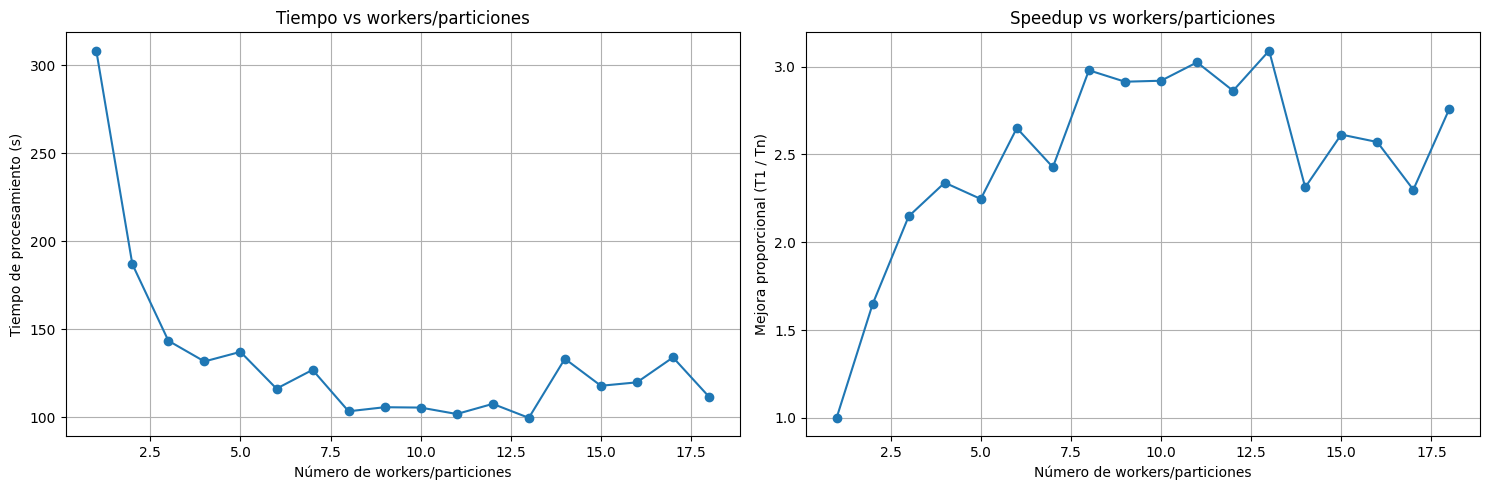

In [11]:
def plot_results_parts_workers(results):
    workers = [r["num_workers_partitions"] for r in results]
    times = [r["execution_time"] for r in results]
    baseline = times[0] if times else 1.0
    speedup = [baseline / t if t else 0 for t in times]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(workers, times, marker='o')
    ax1.set_xlabel("Número de workers/particiones")
    ax1.set_ylabel("Tiempo de procesamiento (s)")
    ax1.set_title("Tiempo vs workers/particiones")
    ax1.grid(True)

    ax2.plot(workers, speedup, marker='o')
    ax2.set_xlabel("Número de workers/particiones")
    ax2.set_ylabel("Mejora proporcional (T1 / Tn)")
    ax2.set_title("Speedup vs workers/particiones")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_results_parts_workers(results)

# Experiment #3 Use of the cache() function and its impact on execution time (1.5 points)

In [21]:
def get_best_configuration(results):
    best = min(results, key=lambda x: x["execution_time"])
    return best

In [22]:
CONFIG_WORKERS_PARTITIONS = get_best_configuration(results).get("num_workers_partitions", None)
CONFIG_WORKERS_PARTITIONS

13

## No cache

Cogemos el run anterior sin cache, no hace falta recalcular.

In [24]:
results_cache = {
    "No cache": get_best_configuration(results).get("execution_time", None),
}
results_cache

{'No cache': 99.69588327407837}

## Cache in read

In [25]:
filename = "/opt/local/botnet_tot_syn_l.csv"

start_time = time.time()
spark = SparkSession.builder.master(f"local[{CONFIG_WORKERS_PARTITIONS}]").appName(f"Test-cache").getOrCreate()
sc = spark.sparkContext
# Read data
data = readFile(filename,sc).cache()
data = data.repartition(CONFIG_WORKERS_PARTITIONS)
print(f"Confirming number of partitions: {data.getNumPartitions()}")
data = normalize(data)
w_b = train(data, GRADIENT_ITERATIONS, LEARNING_RATE, LAMBDA_REG)
end_time = time.time()
results_cache["Cache in fileread"] = end_time - start_time
spark.stop()

Confirming number of partitions: 13


Iteration 0/10, Cost: 0.6068, Accuracy: 0.6764


Iteration 1/10, Cost: 0.4102, Accuracy: 0.8259


Iteration 2/10, Cost: 0.3310, Accuracy: 0.8846


Iteration 3/10, Cost: 0.2904, Accuracy: 0.9016


Iteration 4/10, Cost: 0.2656, Accuracy: 0.9112


Iteration 5/10, Cost: 0.2489, Accuracy: 0.9171


Iteration 6/10, Cost: 0.2368, Accuracy: 0.9212


Iteration 7/10, Cost: 0.2275, Accuracy: 0.9245


Iteration 8/10, Cost: 0.2202, Accuracy: 0.9266


Iteration 9/10, Cost: 0.2142, Accuracy: 0.9282


## Cache after partitioning

In [27]:
filename = "/opt/local/botnet_tot_syn_l.csv"

start_time = time.time()
spark = SparkSession.builder.master(f"local[{CONFIG_WORKERS_PARTITIONS}]").appName(f"Test-cache").getOrCreate()
sc = spark.sparkContext
# Read data
data = readFile(filename,sc)
data = data.repartition(CONFIG_WORKERS_PARTITIONS).cache()
print(f"Confirming number of partitions: {data.getNumPartitions()}")
data = normalize(data)
w_b = train(data, GRADIENT_ITERATIONS, LEARNING_RATE, LAMBDA_REG)
end_time = time.time()
results_cache["Cache in repartition"] = end_time - start_time
spark.stop()

Confirming number of partitions: 13


26/02/22 15:33:00 WARN BlockManager: Task 35 already completed, not releasing lock for rdd_6_0


Iteration 0/10, Cost: 0.6722, Accuracy: 0.6660


Iteration 1/10, Cost: 0.4493, Accuracy: 0.7832


Iteration 2/10, Cost: 0.3509, Accuracy: 0.8540


Iteration 3/10, Cost: 0.3007, Accuracy: 0.8834


Iteration 4/10, Cost: 0.2714, Accuracy: 0.9001


Iteration 5/10, Cost: 0.2522, Accuracy: 0.9102


Iteration 6/10, Cost: 0.2387, Accuracy: 0.9147


Iteration 7/10, Cost: 0.2287, Accuracy: 0.9191


Iteration 8/10, Cost: 0.2209, Accuracy: 0.9223


Iteration 9/10, Cost: 0.2147, Accuracy: 0.9246


## Cache after normalizing

In [30]:
filename = "/opt/local/botnet_tot_syn_l.csv"

start_time = time.time()
spark = SparkSession.builder.master(f"local[{CONFIG_WORKERS_PARTITIONS}]").appName(f"Test-cache").getOrCreate()
sc = spark.sparkContext
# Read data
data = readFile(filename,sc)
data = data.repartition(CONFIG_WORKERS_PARTITIONS).cache()
print(f"Confirming number of partitions: {data.getNumPartitions()}")
data = normalize(data).cache()
data.count()  # Forzar materialización del cache ANTES de medir el training
w_b = train(data, GRADIENT_ITERATIONS, LEARNING_RATE, LAMBDA_REG)
end_time = time.time()
results_cache["Cache in normalize"] = end_time - start_time
spark.stop()

Confirming number of partitions: 13


26/02/22 15:38:23 WARN BlockManager: Task 48 already completed, not releasing lock for rdd_9_0


Iteration 0/10, Cost: 0.6494, Accuracy: 0.6425


Iteration 1/10, Cost: 0.4429, Accuracy: 0.8123


Iteration 2/10, Cost: 0.3534, Accuracy: 0.8710


Iteration 3/10, Cost: 0.3064, Accuracy: 0.8913


Iteration 4/10, Cost: 0.2779, Accuracy: 0.9039


Iteration 5/10, Cost: 0.2587, Accuracy: 0.9126


Iteration 6/10, Cost: 0.2449, Accuracy: 0.9181


Iteration 7/10, Cost: 0.2344, Accuracy: 0.9220


Iteration 8/10, Cost: 0.2261, Accuracy: 0.9247


Iteration 9/10, Cost: 0.2194, Accuracy: 0.9269


In [32]:
results_cache

{'No cache': 99.69588327407837,
 'Cache in fileread': 101.9867491722107,
 'Cache in repartition': 115.56436204910278,
 'Cache in normalize': 101.87130522727966}

In [37]:
from pyspark import RDD

def train_optimized(rdd_xy: RDD, iterations: int, learning_rate: float, lambda_reg: float, show_logs: bool = True) -> tuple[np.ndarray, float]:
    its_to_print = list(range(0, iterations, iterations // 10)) + [iterations]
    k = len(rdd_xy.first()[0])
    m = rdd_xy.count()
    w = np.random.rand(k)
    b = 0

    for it in range(iterations):

        grads = rdd_xy.map(
            lambda x: (
                (predict_proba(w, b, x[0]) - x[1]) * np.array(x[0]),  # contrib dw
                (predict_proba(w, b, x[0]) - x[1])                      # contrib db
            )
        ).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
        # Gradients
        dw = grads[0] / m
        db = grads[1] / m

        # Regularization
        dw += lambda_reg / k * w

        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db

        # Logging
        if show_logs and it in its_to_print:
            c = cost(w, b, rdd_xy, lambda_reg, k, m)
            acc = accuracy(w, b, rdd_xy)
            print(f"Iteration {it}/{iterations}, Cost: {c:.4f}, Accuracy: {acc:.4f}")

    return w, b

In [38]:
filename = "/opt/local/botnet_tot_syn_l.csv"

start_time = time.time()
spark = SparkSession.builder.master(f"local[{CONFIG_WORKERS_PARTITIONS}]").appName(f"Test-cache").getOrCreate()
sc = spark.sparkContext
# Read data
data = readFile(filename,sc)
data = data.repartition(CONFIG_WORKERS_PARTITIONS).cache()
print(f"Confirming number of partitions: {data.getNumPartitions()}")
data = normalize(data).cache()
data.count()  # Forzar materialización del cache ANTES de medir el training
w_b = train_optimized(data, GRADIENT_ITERATIONS, LEARNING_RATE, LAMBDA_REG)
end_time = time.time()
results_cache["Cache with optimized train"] = end_time - start_time
spark.stop()

Confirming number of partitions: 13


26/02/22 15:49:47 WARN BlockManager: Task 48 already completed, not releasing lock for rdd_9_0


Iteration 0/10, Cost: 0.4920, Accuracy: 0.7670


Iteration 1/10, Cost: 0.3538, Accuracy: 0.8793


Iteration 2/10, Cost: 0.2988, Accuracy: 0.9052


Iteration 3/10, Cost: 0.2692, Accuracy: 0.9143


Iteration 4/10, Cost: 0.2503, Accuracy: 0.9201


Iteration 5/10, Cost: 0.2372, Accuracy: 0.9238


Iteration 6/10, Cost: 0.2274, Accuracy: 0.9266


Iteration 7/10, Cost: 0.2198, Accuracy: 0.9284


Iteration 8/10, Cost: 0.2137, Accuracy: 0.9298


Iteration 9/10, Cost: 0.2087, Accuracy: 0.9308


In [39]:
results_cache

{'No cache': 99.69588327407837,
 'Cache in fileread': 101.9867491722107,
 'Cache in repartition': 115.56436204910278,
 'Cache in normalize': 104.96761989593506,
 'Cache with optimized train': 87.70847678184509}